# Offline Signature Verification Using a Siamese Vision Mamba with Contrastive Learning and Visual Explainability

**Objectives**

- Adopt a pre-trained Vision Mamba backbone and integrate it into a Siamese architecture for offline signature verification.  
- Fine-tune the model on offline signature datasets, adapting learned representations for signature-specific features.  
- Employ contrastive learning with contrastive loss to enhance discriminative power.  
- Incorporate visual explainability (e.g., SmoothGrad or Grad-CAM variants) to interpret decisions and highlight signature regions.  
- Evaluate with Accuracy, Equal Error Rate (EER), ROC-AUC, and confusion matrices/histograms on benchmark datasets; compare to baselines.

**This notebook has been patched to:**
- Ensure **balanced per-split** pairs (`N` genuine and `N` forged), adding **impostors only when needed** and strictly **not in excess**.  
- Preserve **writer-disjoint** 70/20/10 splits and avoid leakage.  
- Provide a clear **SiameseNet (Vision Mamba) summary** including inputs, embeddings (`e1`, `e2`) and distance head output shapes.  
- Add a **`predict_score`** helper for visualizing a random test pair and the model’s decision at a given threshold.


**CONFIG**

In [8]:
# CONFIG
import os, random, numpy as np, torch
from pathlib import Path

# Try common locations; pick the first that exists
candidates = [
    Path(r"C:\Users\megel\Documents\signature-mamba\cedar_dataset"),
    Path("cedar_dataset"),
    Path("./data/CEDAR"),
    Path("data/cedar_dataset"),
]
ROOT_PATH = next((c for c in candidates if c.exists()), None)
if ROOT_PATH is None:
    raise FileNotFoundError("Put the dataset under 'cedar_dataset' (with full_org/ and full_forg/).")
ROOT = str(ROOT_PATH.resolve())

# Request a Vision Mamba; we'll pick the closest available later
REQUESTED_BACKBONE = "mambaout_tiny.in1k"

# Image + training hyperparams
SIZE    = 224
BATCH   = 16
EPOCHS  = 30          # ceiling lang; early stopping will cut sooner
LR      = 2e-4
MARGIN  = 0.7
SEED    = 123

# RMSprop (Keras-like)
RMS_LR  = 1e-4
RMS_RHO = 0.9
RMS_EPS = 1e-8

# --- knobs that usually help metrics ---
THRESH_MODE = "youden"          # "maxacc" | "youden" | "eer"
FREEZE_EPOCHS = 2               # freeze backbone first N epochs, then unfreeze
UNFREEZE_BACKBONE_LR_MULT = 0.25
USE_STRONG_AUG = True           # stronger but safe aug for signatures
RESAMPLE_TRAIN_EVERY_EPOCH = True  # new pair combos each epoch

# Keep runtime practical (pairs can explode)
CAP_TOTAL_PAIRS       = 140_000    # total pairs BEFORE 70/20/10
MAX_STEPS_PER_EPOCH   = None       # set number or keep None for full
WRITER_DISJOINT_SPLIT = True       # split by signer (recommended)

# Early stopping
ES_PATIENCE = 5                   # epochs w/o val_loss improvement before stop

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
    torch.backends.cudnn.benchmark = True

print("DEVICE:", DEVICE)
print("ROOT:", ROOT)
print("Subfolders:", [p.name for p in Path(ROOT).iterdir() if p.is_dir()])


DEVICE: cuda
ROOT: C:\Users\megel\Documents\signature-mamba\cedar_dataset
Subfolders: ['full_forg', 'full_org']


**Safety-first config overrides**

In [10]:

# === SAFE DEFAULTS OVERRIDE (no data peeking, deterministic) ===
SEED = 1337
WRITER_DISJOINT_SPLIT = True
CAP_TOTAL_PAIRS = CAP_TOTAL_PAIRS if 'CAP_TOTAL_PAIRS' in globals() and CAP_TOTAL_PAIRS else 140_000
MAX_STEPS_PER_EPOCH = MAX_STEPS_PER_EPOCH if 'MAX_STEPS_PER_EPOCH' in globals() and MAX_STEPS_PER_EPOCH else None
EPOCHS = max(10, int(EPOCHS)) if 'EPOCHS' in globals() else 30
LR = LR if 'LR' in globals() else 3e-4
MARGIN = MARGIN if 'MARGIN' in globals() else 1.0


**DATASET & LOADERS (+ caching, writer-disjoint split)**

In [11]:
# === DATASET & LOADERS (balanced pairs per split) ===
from typing import Optional, List, Tuple
from collections import defaultdict
from PIL import Image
import itertools, re, hashlib, random
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

# Jupyter/VS Code friendly progress bars
try:
    from tqdm.notebook import tqdm
except Exception:
    from tqdm.auto import tqdm

# Optional OpenCV (faster binarize+crop). Fallback if missing.
try:
    import cv2
    HAVE_CV2 = True
except Exception:
    HAVE_CV2 = False

class PairSample:
    def __init__(self, img1_path: Path, img2_path: Path, label: int):
        self.img1_path = img1_path
        self.img2_path = img2_path
        self.label = label  # 1 = same (Genuine), 0 = Forged/Impostor

def signer_key(name: str) -> str:
    parts = re.sub(r"[-_]", ".", name).split(".")
    for t in parts:
        if t.isdigit():
            return t
    return "unknown"

def _gather_images(dirpath: Path) -> List[Path]:
    exts = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")
    return [p for p in dirpath.rglob("*") if p.suffix.lower() in exts]

def _first_existing(parent: Path, names: List[str]) -> Path | None:
    parent = parent.resolve()
    for n in names:
        p = parent / n
        if p.exists() and p.is_dir():
            return p
    return None

# --- preprocessing (binarize + tight crop) with disk cache ---
CACHE_DIR = Path("cache_preproc"); CACHE_DIR.mkdir(exist_ok=True)

def _cache_key(p: Path):
    s = f"{str(p.resolve())}|{p.stat().st_mtime_ns}"
    return hashlib.md5(s.encode()).hexdigest() + ".pt"

def binarize_and_crop(pil_img: Image.Image) -> Image.Image:
    if not HAVE_CV2:
        return pil_img.convert("L").convert("RGB")
    img = np.array(pil_img.convert("L"))
    _, thr = cv2.threshold(255 - img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cnts, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return pil_img.convert("RGB")
    c = max(cnts, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    pad = int(0.05 * max(w,h))
    x0 = max(0, x - pad); y0 = max(0, y - pad)
    x1 = min(img.shape[1], x + w + pad); y1 = min(img.shape[0], y + h + pad)
    crop = img[y0:y1, x0:x1]
    crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(crop)

def load_preprocessed_as_pil_rgb(p: Path) -> Image.Image:
    key = _cache_key(p); f = CACHE_DIR / key
    if f.exists():
        ten = torch.load(f)  # 1xHxW float [0..1]
        arr = (ten.squeeze(0).numpy() * 255).astype(np.uint8)
        return Image.fromarray(arr).convert("RGB")
    pil = binarize_and_crop(Image.open(p))
    arr = np.asarray(pil.convert("L"), dtype=np.uint8).copy()
    ten = torch.from_numpy(arr).unsqueeze(0).to(torch.float32) / 255.0
    torch.save(ten, f)
    return pil

def scan_dataset(root: str):
    root = Path(root).resolve()
    ORG_CANDIDATES  = ["ful_org","full_org","original","originals","genuine","genuines"]
    FORG_CANDIDATES = ["full_forg","forg","forgery","forgeries","forged","impostor","impostors"]
    org_dir = _first_existing(root, ORG_CANDIDATES)
    forg_dir = _first_existing(root, FORG_CANDIDATES)
    if org_dir is None or forg_dir is None:
        raise FileNotFoundError(
            f"Could not find originals or forgeries dirs under {root}. "
            f"Tried originals={ORG_CANDIDATES}, forgeries={FORG_CANDIDATES}"
        )
    org_by_signer = defaultdict(list)
    for p in _gather_images(org_dir):
        org_by_signer[signer_key(p.name)].append(p)

    forg_by_signer = defaultdict(list)
    for p in _gather_images(forg_dir):
        forg_by_signer[signer_key(p.name)].append(p)

    return org_by_signer, forg_by_signer

def split_signers(all_signers: List[str], ratios=(0.7,0.2,0.1), seed=123):
    rng = random.Random(seed)
    ss = list(all_signers); rng.shuffle(ss)
    n = len(ss); n_train = int(ratios[0]*n); n_val = int(ratios[1]*n)
    trainS = set(ss[:n_train]); valS = set(ss[n_train:n_train+n_val]); testS = set(ss[n_train+n_val:])
    return trainS, valS, testS

# ---------- BALANCED PAIR BUILDER (impostors only if needed) ----------
def _enumerate_positive_pairs(org_by_signer, signer_subset) -> List[PairSample]:
    pos = []
    for s in signer_subset:
        imgs = org_by_signer.get(s, [])
        if len(imgs) < 2:
            continue
        for i in range(len(imgs)):
            for j in range(i+1, len(imgs)):
                pos.append(PairSample(imgs[i], imgs[j], 1))
    return pos

def _enumerate_skilled_negatives(org_by_signer, forg_by_signer, signer_subset) -> List[PairSample]:
    neg = []
    for s in signer_subset:
        orgs = org_by_signer.get(s, [])
        forgs = forg_by_signer.get(s, [])
        for o in orgs:
            for f in forgs:
                neg.append(PairSample(o, f, 0))
    return neg

def _add_impostors_until(neg: List[PairSample], target_count: int, org_by_signer, signer_subset, rng: random.Random):
    """Add impostor pairs (original vs original from different signers) only up to target_count."""
    if len(neg) >= target_count:
        return

    signers = [s for s in signer_subset if len(org_by_signer.get(s, [])) > 0]
    if len(signers) < 2:
        return

    # Uniqueness: avoid (a,b) and (b,a) duplicates and duplicates vs existing negatives
    seen = set()
    for p in neg:
        k = (min(str(p.img1_path), str(p.img2_path)), max(str(p.img1_path), str(p.img2_path)))
        seen.add(k)

    # conservative upper bound on trials
    need = target_count - len(neg)
    max_trials = max(1000, 20 * need)
    trials = 0

    while len(neg) < target_count and trials < max_trials:
        s1, s2 = rng.sample(signers, 2)
        o1 = rng.choice(org_by_signer[s1])
        o2 = rng.choice(org_by_signer[s2])
        k = (min(str(o1), str(o2)), max(str(o1), str(o2)))
        if k in seen:
            trials += 1
            continue
        seen.add(k)
        neg.append(PairSample(o1, o2, 0))
        trials += 1

def build_pairs_for_signers_balanced(
    org_by_signer,
    forg_by_signer,
    signer_subset,
    rng: random.Random
) -> Tuple[List[PairSample], List[PairSample], List[PairSample]]:
    """
    Build pairs for a signer subset and return:
      - pos_pairs (genuine/genuine)
      - neg_pairs (forgery + minimal impostors if needed)
      - all_pairs (shuffled, with exactly N positives & N negatives)
    """
    pos_pairs = _enumerate_positive_pairs(org_by_signer, signer_subset)
    neg_pairs = _enumerate_skilled_negatives(org_by_signer, forg_by_signer, signer_subset)

    if len(pos_pairs) == 0 and len(neg_pairs) == 0:
        raise RuntimeError("No pairs found; check dataset completeness.")

    # If skilled negatives fewer than positives, top up with impostors only as needed
    if len(neg_pairs) < len(pos_pairs):
        _add_impostors_until(neg_pairs, target_count=len(pos_pairs), org_by_signer=org_by_signer, signer_subset=signer_subset, rng=rng)

    # Choose N = min(len(pos), len(neg)) and return exactly N of each
    rng.shuffle(pos_pairs); rng.shuffle(neg_pairs)
    N = min(len(pos_pairs), len(neg_pairs))
    pos_pairs = pos_pairs[:N]
    neg_pairs = neg_pairs[:N]

    all_pairs = pos_pairs + neg_pairs
    rng.shuffle(all_pairs)
    return pos_pairs, neg_pairs, all_pairs

# Backward-compatible wrapper name (for any older calls)
def build_pairs_for_signers(org_by_signer, forg_by_signer, signer_subset, rng):
    _, _, all_pairs = build_pairs_for_signers_balanced(org_by_signer, forg_by_signer, signer_subset, rng)
    return all_pairs

class PairsDataset(Dataset):
    def __init__(self, pairs: List[PairSample], size: int, split: str):
        self.samples = pairs
        aug = []
        if split == "train":
            if USE_STRONG_AUG:
                aug = [
                    T.RandomApply([T.RandomRotation(degrees=3)], p=0.4),
                    T.RandomApply([T.RandomAffine(degrees=3, translate=(0.02,0.02), scale=(0.98,1.02), shear=2)], p=0.5),
                    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.3),
                ]
            else:
                aug = [
                    T.RandomApply([T.RandomRotation(degrees=3)], p=0.5),
                    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.3),
                ]
        self.tf = T.Compose([
            T.Lambda(lambda im: binarize_and_crop(im)),
            *aug,
            T.Resize((size, size)),
            T.ToTensor(),
            T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
        ])

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        im1 = load_preprocessed_as_pil_rgb(s.img1_path)
        im2 = load_preprocessed_as_pil_rgb(s.img2_path)
        x1 = self.tf(im1); x2 = self.tf(im2)
        y = torch.tensor([s.label], dtype=torch.float32)
        return x1, x2, y

# ---- Hash-based leakage guard helpers (used inside make_loaders) ----
def _file_md5(path, chunk=1<<16):
    h = hashlib.md5()
    with open(path,'rb') as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def _hash_maps(org_by_signer, forg_by_signer):
    H = {}
    for s, lst in org_by_signer.items():
        for p in lst:
            H.setdefault(_file_md5(p), set()).add(("org", s, p))
    for s, lst in forg_by_signer.items():
        for p in lst:
            H.setdefault(_file_md5(p), set()).add(("forg", s, p))
    return H

def _assert_no_hash_crosssplit(trainS, valS, testS, H):
    def bucket(signer):
        if signer in trainS: return "train"
        if signer in valS:   return "val"
        if signer in testS:  return "test"
        return "none"
    for md5, entries in H.items():
        splits = {bucket(s) for (_, s, _) in entries}
        splits.discard("none")
        if len(splits) > 1:
            raise AssertionError(f"Duplicate image content found across splits for hash={md5} in {splits}")

def _sample_balanced(pos_pairs: List[PairSample], neg_pairs: List[PairSample], target_total: Optional[int], rng: random.Random) -> List[PairSample]:
    """
    Preserve 1:1 balance under caps: keep k pos and k neg where k = min(len(pos), len(neg), target_total//2).
    """
    if (target_total is None) or (target_total <= 0):
        pairs = pos_pairs + neg_pairs
        rng.shuffle(pairs)
        return pairs
    k = min(len(pos_pairs), len(neg_pairs), target_total // 2)
    pos_subset = pos_pairs[:k]
    neg_subset = neg_pairs[:k]
    pairs = pos_subset + neg_subset
    rng.shuffle(pairs)
    return pairs

def make_loaders(root: str, size: int, batch: int, seed: int, cap_total_pairs: Optional[int], writer_disjoint=True):
    rng = random.Random(seed)
    org_by_signer, forg_by_signer = scan_dataset(root)

    if writer_disjoint:
        signers = sorted(set(org_by_signer.keys()) | set(forg_by_signer.keys()))
        trainS, valS, testS = split_signers(signers, (0.7,0.2,0.1), seed)
        # Leakage guard
        H = _hash_maps(org_by_signer, forg_by_signer)
        _assert_no_hash_crosssplit(trainS, valS, testS, H)

        # Build BALANCED pairs per split
        tr_pos, tr_neg, _ = build_pairs_for_signers_balanced(org_by_signer, forg_by_signer, trainS, rng)
        va_pos, va_neg, _ = build_pairs_for_signers_balanced(org_by_signer, forg_by_signer, valS, rng)
        te_pos, te_neg, _ = build_pairs_for_signers_balanced(org_by_signer, forg_by_signer, testS, rng)

        # Respect cap while keeping balance 1:1 per split
        if cap_total_pairs is not None:
            cap_total_pairs = int(cap_total_pairs)
            cap_tr = int(0.7 * cap_total_pairs)
            cap_va = int(0.2 * cap_total_pairs)
            cap_te = max(1, cap_total_pairs - cap_tr - cap_va)
            train_pairs = _sample_balanced(tr_pos, va_neg if False else tr_neg, cap_tr, rng)  # ensure same split
            val_pairs   = _sample_balanced(va_pos, va_neg, cap_va, rng)
            test_pairs  = _sample_balanced(te_pos, te_neg, cap_te, rng)
        else:
            train_pairs = _sample_balanced(tr_pos, tr_neg, None, rng)
            val_pairs   = _sample_balanced(va_pos, va_neg, None, rng)
            test_pairs  = _sample_balanced(te_pos, te_neg, None, rng)
    else:
        # Non writer-disjoint (not recommended): build once, then 70/20/10 after balance
        signers = set(org_by_signer.keys()) | set(forg_by_signer.keys())
        pos_all, neg_all, all_bal = build_pairs_for_signers_balanced(org_by_signer, forg_by_signer, signers, rng)
        # Split AFTER balancing; then cap each in proportion
        n = len(all_bal); n_train = int(0.7*n); n_val = int(0.2*n)
        train_pairs, val_pairs, test_pairs = all_bal[:n_train], all_bal[n_train:n_train+n_val], all_bal[n_train+n_val:]
        if cap_total_pairs is not None:
            # Re-balance under caps by sampling equal halves from each label
            def rebalance_under_cap(pairs, target):
                rng.shuffle(pairs)
                pos = [p for p in pairs if p.label==1]
                neg = [p for p in pairs if p.label==0]
                return _sample_balanced(pos, neg, target, rng)
            cap_tr = int(0.7 * cap_total_pairs)
            cap_va = int(0.2 * cap_total_pairs)
            cap_te = max(1, cap_total_pairs - cap_tr - cap_va)
            train_pairs = rebalance_under_cap(train_pairs, cap_tr)
            val_pairs   = rebalance_under_cap(val_pairs, cap_va)
            test_pairs  = rebalance_under_cap(test_pairs, cap_te)

    train_ds = PairsDataset(train_pairs, size, "train")
    val_ds   = PairsDataset(val_pairs, size, "val")
    test_ds  = PairsDataset(test_pairs, size, "test")

    g = torch.Generator().manual_seed(seed)
    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True,  num_workers=0, pin_memory=True, generator=g)
    val_loader   = DataLoader(val_ds,   batch_size=batch, shuffle=False, num_workers=0, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch, shuffle=False, num_workers=0, pin_memory=True)

    # Simple sanity print with class balance per split
    ntr_pos = sum(1 for p in train_pairs if p.label==1); ntr_neg = len(train_pairs) - ntr_pos
    nva_pos = sum(1 for p in val_pairs   if p.label==1); nva_neg = len(val_pairs)   - nva_pos
    nte_pos = sum(1 for p in test_pairs  if p.label==1); nte_neg = len(test_pairs)  - nte_pos
    print(f"[BAL] Pairs -> train: {len(train_ds)} (pos={ntr_pos}, neg={ntr_neg}) | "
          f"val: {len(val_ds)} (pos={nva_pos}, neg={nva_neg}) | "
          f"test: {len(test_ds)} (pos={nte_pos}, neg={nte_neg})")

    return train_loader, val_loader, test_loader


In [ ]:
# 1) Pick the first that exists
root = None
for p in candidates:
    if p.exists():
        root = p.resolve()
        break

if root is None:
    raise FileNotFoundError("None of the candidate dataset paths exist. Please double-check the folders.")

print(f"Using dataset root: {root}")

# 2) Load groups with your helpers
org_by_signer, forg_by_signer = scan_dataset(str(root))

# 3) Quick counts
orig_groups = list(org_by_signer.values())
forg_groups = list(forg_by_signer.values())
print("Quick check to confirm we have data of all individuals")
print("len(orig_groups), len(forg_groups) ->", (len(orig_groups), len(forg_groups)))

# 4) Per-signer lengths (sorted by signer ID for stable order)
all_signers = sorted(set(org_by_signer.keys()) | set(forg_by_signer.keys()))
orig_lengths = [len(org_by_signer.get(s, [])) for s in all_signers]
forg_lengths = [len(forg_by_signer.get(s, [])) for s in all_signers]

print("\nQuick check to confirm Genuine signatures per individual")
print(orig_lengths)
print("Unique counts among genuine:", sorted(set(orig_lengths)))

print("\nQuick check to confirm Forged signatures per individual")
print(forg_lengths)
print("Unique counts among forged:", sorted(set(forg_lengths)))

# 5) Optional: validate against typical CEDAR counts (24 genuine, 24 forged)
EXPECTED_ORIG = 24
EXPECTED_FORG = 24  # or 30 if that's your dataset

bad_orig = [s for s in all_signers if len(org_by_signer.get(s, [])) != EXPECTED_ORIG]
bad_forg = [s for s in all_signers if len(forg_by_signer.get(s, [])) != EXPECTED_FORG]

if bad_orig or bad_forg:
    print("\nSigners with unexpected counts:")
    for s in bad_orig:
        cnt = len(org_by_signer.get(s, []))
        print(f"  {s}: genuine={cnt} (expected {EXPECTED_ORIG})")
    for s in bad_forg:
        cnt = len(forg_by_signer.get(s, []))
        print(f"  {s}: forged={cnt} (expected {EXPECTED_FORG})")


SyntaxError: unterminated string literal (detected at line 46) (2910273653.py, line 46)

**Overrides to enforce leak-proof splits**

In [4]:
# === SAFEGUARDS: writer-disjoint split, deterministic sampling, and duplicate guard ===
# NOTE: The actual pair building + make_loaders are now defined in Cell 3 (balanced).
# This cell keeps helpers visible for debugging without redefining build_pairs_for_signers/make_loaders.

import hashlib
from collections import defaultdict

def _file_md5(path, chunk=1<<16):
    h=hashlib.md5()
    with open(path,'rb') as f:
        while True:
            b=f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def _hash_maps(org_by_signer, forg_by_signer):
    H = {}
    for s, lst in org_by_signer.items():
        for p in lst:
            H.setdefault(_file_md5(p), set()).add(("org", s, p))
    for s, lst in forg_by_signer.items():
        for p in lst:
            H.setdefault(_file_md5(p), set()).add(("forg", s, p))
    return H

def _assert_no_hash_crosssplit(trainS, valS, testS, H):
    def bucket(signer):
        if signer in trainS: return "train"
        if signer in valS:   return "val"
        if signer in testS:  return "test"
        return "none"
    for md5, entries in H.items():
        splits = {bucket(s) for (_, s, _) in entries}
        splits.discard("none")
        if len(splits) > 1:
            raise AssertionError(f"Duplicate image content found across splits for hash={md5} in {splits}")

print("Safeguard helpers are defined and used inside make_loaders (Cell 3).")


Safeguard helpers are defined and used inside make_loaders (Cell 3).


**PARTITION SUMMARY + LEAKAGE CHECK**
* Summarizes signer counts and image counts per split.
* Rebuilds pairs (with optional global cap).
* Leakage check: Reports overlaps between sets of signers across splits. “No data leakage detected.” when disjoint.

#### Train-Validation-Test Split
* Signatures of 70% people are used for training
* Signatures of 20%  people are used for validation
* Signatures of 10% people are used for testing


In [5]:
# PARTITION SUMMARY + BALANCE CHECK
def summarize_partitions(root: str, seed: int = SEED, ratios=(0.7,0.2,0.1), cap_total_pairs: int | None = CAP_TOTAL_PAIRS):
    rng = random.Random(seed)
    org_by_signer, forg_by_signer = scan_dataset(root)
    signers = sorted(set(org_by_signer.keys()) | set(forg_by_signer.keys()))

    n_total = len(signers)
    n_train_tgt = int(ratios[0]*n_total); n_val_tgt = int(ratios[1]*n_total); n_test_tgt = n_total - n_train_tgt - n_val_tgt
    trainS, valS, testS = split_signers(signers, ratios, seed)

    def count_imgs(subset):
        gen = sum(len(org_by_signer.get(s, [])) for s in subset)
        forg = sum(len(forg_by_signer.get(s, [])) for s in subset)
        return gen, forg

    g_tr, f_tr = count_imgs(trainS)
    g_va, f_va = count_imgs(valS)
    g_te, f_te = count_imgs(testS)

    # Build balanced pairs per split, then apply same cap logic as make_loaders
    tr_pos, tr_neg, _ = build_pairs_for_signers_balanced(org_by_signer, forg_by_signer, trainS, rng)
    va_pos, va_neg, _ = build_pairs_for_signers_balanced(org_by_signer, forg_by_signer, valS, rng)
    te_pos, te_neg, _ = build_pairs_for_signers_balanced(org_by_signer, forg_by_signer, testS, rng)

    if cap_total_pairs is not None:
        cap_total_pairs = int(cap_total_pairs)
        cap_tr = int(ratios[0]*cap_total_pairs)
        cap_va = int(ratios[1]*cap_total_pairs)
        cap_te = max(1, cap_total_pairs - cap_tr - cap_va)
        def _cap(pos, neg, targ):
            rng.shuffle(pos); rng.shuffle(neg)
            k = min(len(pos), len(neg), targ//2)
            return 2*k, k, k
        tr_all, trp, trn = _cap(tr_pos, tr_neg, cap_tr)
        va_all, vap, van = _cap(va_pos, va_neg, cap_va)
        te_all, tep, ten = _cap(te_pos, te_neg, cap_te)
    else:
        tr_all, trp, trn = 2*min(len(tr_pos), len(tr_neg)), min(len(tr_pos), len(tr_neg)), min(len(tr_pos), len(tr_neg))
        va_all, vap, van = 2*min(len(va_pos), len(va_neg)), min(len(va_pos), len(va_neg)), min(len(va_pos), len(va_neg))
        te_all, tep, ten = 2*min(len(te_pos), len(te_neg)), min(len(te_pos), len(te_neg)), min(len(te_pos), len(te_neg))

    print(f"Pairs -> train: {tr_all:,} | val: {va_all:,} | test: {te_all:,}")
    print(f"Total writers: {n_total} | target≈ train {n_train_tgt}, val {n_val_tgt}, test {n_test_tgt}")
    print(f"Actual writers: train={len(trainS)}, val={len(valS)}, test={len(testS)}\n")

    print("--- Partition Summary (images) ---")
    print(f"{'Partition':<10} {'Num Signers':>12} {'Genuine Sigs':>14} {'Forged Sigs':>13}")
    print(f"{'Train':<10} {len(trainS):>12} {g_tr:>14} {f_tr:>13}")
    print(f"{'Validation':<10} {len(valS):>12} {g_va:>14} {f_va:>13}")
    print(f"{'Test':<10} {len(testS):>12} {g_te:>14} {f_te:>13}\n")

    print("--- Balanced Pair Counts (kept) ---")
    print(f"{'Partition':<10} {'Pos (y=1)':>12} {'Neg (y=0)':>12}")
    print(f"{'Train':<10} {trp:>12} {trn:>12}")
    print(f"{'Validation':<10} {vap:>12} {van:>12}")
    print(f"{'Test':<10} {tep:>12} {ten:>12}")

# Run summary
summarize_partitions(ROOT, seed=SEED, ratios=(0.7,0.2,0.1), cap_total_pairs=CAP_TOTAL_PAIRS)


Pairs -> train: 20,976 | val: 6,072 | test: 3,312
Total writers: 55 | target≈ train 38, val 11, test 6
Actual writers: train=38, val=11, test=6

--- Partition Summary (images) ---
Partition   Num Signers   Genuine Sigs   Forged Sigs
Train                38            912           912
Validation           11            264           264
Test                  6            144           144

--- Balanced Pair Counts (kept) ---
Partition     Pos (y=1)    Neg (y=0)
Train             10488        10488
Validation         3036         3036
Test               1656         1656


**MODEL (Vision Mamba backbone + Siamese + Contrastive)**

In [6]:
# MODEL
import torch.nn as nn
import torch.nn.functional as F
import torch

try:
    import timm
    HAVE_TIMM = True
except Exception:
    HAVE_TIMM = False

try:
    import torchvision.models as tvm
    HAVE_TV = True
except Exception:
    HAVE_TV = False

def pick_backbone_name(requested: str) -> str:
    if HAVE_TIMM:
        avail = set(timm.list_models("*"))
        if requested in avail:
            return requested
        base = requested.replace(".in1k", "")
        if base in avail:
            print(f"[BACKBONE] Using closest: {base}")
            return base
        m = [m for m in avail if "mamba" in m.lower()]
        if m:
            pref = [x for x in m if ("tiny" in x.lower() or "224" in x.lower())]
            chosen = pref[0] if pref else m[0]
            print(f"[BACKBONE] Using closest: {chosen}")
            return chosen
    if HAVE_TV:
        print("[BACKBONE] Falling back to torchvision resnet18")
        return "tv-resnet18"
    print("[BACKBONE] Falling back to tiny-cnn")
    return "tiny-cnn"

def _ensure_vec(z: torch.Tensor) -> torch.Tensor:
    if z.ndim == 4:   # (B,C,H,W)
        z = z.mean(dim=(2,3))
    elif z.ndim == 3: # (B,L,C)
        z = z.mean(dim=1)
    elif z.ndim == 2:
        pass
    else:
        z = z.view(z.size(0), -1)
    return z

class VisionBackbone(nn.Module):
    def __init__(self, name: str):
        super().__init__()
        self.name = name
        if HAVE_TIMM and not name.startswith("tv-") and name != "tiny-cnn":
            self.encoder = timm.create_model(name, pretrained=True, num_classes=0, global_pool='avg')
            probe = torch.zeros(1,3,224,224)
            with torch.no_grad():
                self.encoder.eval()
                try:
                    out = self.encoder(probe)
                except Exception:
                    feats = self.encoder.forward_features(probe)  # type: ignore[attr-defined]
                    if isinstance(feats, (list,tuple)): feats = feats[-1]
                    out = _ensure_vec(feats)
                out = _ensure_vec(out)
            self.out_dim = int(out.shape[-1])
        elif name == "tv-resnet18" and HAVE_TV:
            m = tvm.resnet18(weights=tvm.ResNet18_Weights.DEFAULT)
            m.fc = nn.Identity()
            self.encoder = m
            self.out_dim = 512
        else:
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, 3, 2, 1), nn.ReLU(),
                nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
                nn.Conv2d(64, 128,3, 2, 1), nn.ReLU(),
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten()
            )
            self.out_dim = 128
        print(f"[VisionBackbone] {self.name} -> out_dim={self.out_dim}")

    def forward(self, x):
        z = self.encoder(x)
        return _ensure_vec(z)

class SiameseNet(nn.Module):
    def __init__(self, backbone_name: str, proj_dim: int = 512):
        super().__init__()
        self.backbone = VisionBackbone(backbone_name)
        in_dim = self.backbone.out_dim
        self.head = nn.Sequential(
            nn.Linear(in_dim, proj_dim),
            nn.BatchNorm1d(proj_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.10),
            nn.Linear(proj_dim, proj_dim),
        )

    def embed(self, x):
        z = self.backbone(x)
        z = self.head(z)
        return F.normalize(z, dim=-1)

    def forward(self, x1, x2):
        e1 = self.embed(x1)
        e2 = self.embed(x2)
        d  = torch.norm(e1 - e2, p=2, dim=-1, keepdim=True)
        return d, e1, e2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin: float = 1.0):
        super().__init__()
        self.m = margin
    def forward(self, dist, y):
        pos = y * (dist**2)
        neg = (1-y) * torch.clamp(self.m - dist, min=0.0)**2
        return (pos + neg).mean()

BACKBONE = pick_backbone_name(REQUESTED_BACKBONE)
print("BACKBONE:", BACKBONE)


[BACKBONE] Using closest: mambaout_tiny
BACKBONE: mambaout_tiny


**METRIC HELPERS (acc/f1/FAR/FRR/AUC, Youden threshold)**

In [7]:
#METRIC HELPERS
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

def pick_threshold_for_max_acc(distances: np.ndarray, labels: np.ndarray, bins=120):
    d = distances.flatten(); y = labels.flatten().astype(int)
    ths = np.linspace(d.min(), d.max(), bins)
    best_acc, best_th = -1.0, ths[0]
    for th in ths:
        pred = (d < th).astype(int)
        acc = (pred == y).mean()
        if acc > best_acc:
            best_acc, best_th = acc, th
    return float(best_th)

def pick_threshold_youden(distances: np.ndarray, labels: np.ndarray):
    scores = -distances.flatten()  # higher=more likely "same"
    y = labels.flatten().astype(int)
    fpr, tpr, ths = roc_curve(y, scores)
    j = tpr - fpr
    i = np.argmax(j)
    return float(-ths[i])  # back to distance threshold

def far_frr_at_threshold(distances: np.ndarray, labels: np.ndarray, th: float):
    y = labels.flatten().astype(int)
    pred_pos = (distances.flatten() < th)
    neg = (y == 0); pos = (y == 1)
    fp = np.sum(pred_pos & neg); fn = np.sum((~pred_pos) & pos)
    far = fp / max(1, np.sum(neg))
    frr = fn / max(1, np.sum(pos))
    return float(far), float(frr)

def auc_from_dist(distances: np.ndarray, labels: np.ndarray):
    scores = -distances.flatten()
    y = labels.flatten().astype(int)
    return float(roc_auc_score(y, scores))


**EER / ROC-AUC / PR-AUC + Curves**

In [8]:
#  metric helpers: EER / ROC-AUC / PR-AUC / Curves
import matplotlib.pyplot as plt
try:
    from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
    HAVE_SK_METRICS = True
except Exception:
    HAVE_SK_METRICS = False

import torch

@torch.no_grad()
def collect_scores(model, loader, device, max_steps=None):
    model.eval()
    dists, labels, steps = [], [], 0
    for (x1, x2, y) in loader:
        x1, x2 = x1.to(device), x2.to(device)
        d, _, _ = model(x1, x2)
        dists.append(d.cpu().numpy()); labels.append(y.numpy())
        steps += 1
        if (max_steps is not None) and (steps >= max_steps): break
    if not dists: return np.array([]), np.array([])
    return np.concatenate(dists, axis=0).squeeze(-1), np.concatenate(labels, axis=0).astype(int).squeeze(-1)

def compute_eer(distances: np.ndarray, labels: np.ndarray):
    ths = np.unique(np.sort(distances))
    ths = np.concatenate([[ths[0]-1e-6], ths, [ths[-1]+1e-6]])
    y = labels.astype(int)
    FAR_list, FRR_list = [], []
    for th in ths:
        pred_pos = distances < th
        FAR = (pred_pos & (y==0)).sum() / max(1, (y==0).sum())
        FRR = ((~pred_pos) & (y==1)).sum() / max(1, (y==1).sum())
        FAR_list.append(FAR); FRR_list.append(FRR)
    FAR_arr, FRR_arr = np.array(FAR_list), np.array(FRR_list)
    i = np.argmin(np.abs(FAR_arr - FRR_arr))
    eer = (FAR_arr[i] + FRR_arr[i]) / 2.0
    return float(eer), float(ths[i]), FAR_arr, FRR_arr

def plot_curves(distances: np.ndarray, labels: np.ndarray, note="(test)"):
    scores = -distances  # higher = more likely "same"
    if HAVE_SK_METRICS:
        fpr, tpr, _ = roc_curve(labels, scores)
        roc_auc = roc_auc_score(labels, scores)
        prec, rec, _ = precision_recall_curve(labels, scores)
        ap = average_precision_score(labels, scores)
    else:
        qs = np.linspace(scores.min(), scores.max(), 200)
        y = labels.astype(int)
        tpr, fpr, prec, rec = [], [], [], []
        for q in qs:
            pred = (scores >= q)
            tp = ((pred==1)&(y==1)).sum(); fp = ((pred==1)&(y==0)).sum()
            fn = ((pred==0)&(y==1)).sum(); tn = ((pred==0)&(y==0)).sum()
            tpr.append(tp / max(1, tp+fn)); fpr.append(fp / max(1, fp+tn))
            precision = tp / max(1, tp+fp); recall = tp / max(1, tp+fn)
            prec.append(precision); rec.append(recall)
        roc_auc = float(np.trapz(sorted(tpr), sorted(fpr)))
        ap = float(np.trapz(sorted(prec), sorted(rec)))

    eer, eer_th, FAR_arr, FRR_arr = compute_eer(distances, labels)

    plt.figure(figsize=(5.2,4)); plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--',lw=1); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC {note}"); plt.legend(); plt.show()

    plt.figure(figsize=(5.2,4)); plt.plot(rec, prec, label=f"AP={ap:.4f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR {note}"); plt.legend(); plt.show()

    plt.figure(figsize=(5.2,4)); plt.plot(FAR_arr, FRR_arr)
    plt.xlabel("FAR"); plt.ylabel("FRR"); plt.title(f"DET {note}"); plt.grid(True, ls="--", alpha=0.4); plt.show()

    print(f"EER={eer:.4f} at threshold={eer_th:.4f}")
    print(f"ROC AUC={roc_auc:.4f} | PR AUC (AP)={ap:.4f}")
    return {"EER":eer, "EER_threshold":eer_th, "ROC_AUC":roc_auc, "AP":ap}


**Overrides for robust training**

In [9]:

# === TRAINING SAFEGUARDS: early stopping, gradient clipping, strict validation threshold ===
import math, time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pathlib import Path

from contextlib import nullcontext
# PyTorch autocast compatibility across versions
try:
    autocast = torch.autocast  # torch>=2.0
    def _amp_ctx(enabled, device):
        return autocast(device_type=device, enabled=enabled)
except AttributeError:
    from torch.cuda.amp import autocast  # torch<2.0
    def _amp_ctx(enabled, device):
        return autocast() if (enabled and device=='cuda') else nullcontext()


def fit(root, backbone, size, batch, epochs, lr, margin, seed, device, save_dir,
        cap_total_pairs=None, max_steps_per_epoch=None, writer_disjoint=True,
        patience=8, clip_max_norm=1.0):
    train_loader, val_loader, test_loader = make_loaders(root, size, batch, seed, cap_total_pairs, writer_disjoint)
    model = SiameseNet(backbone).to(device)
    loss_fn = ContrastiveLoss(margin)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3, verbose=True)
    use_amp = (device == "cuda")
    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

    best = {"score": -1.0, "state": None, "threshold": 0.5}
    history = []
    no_improve = 0

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        steps = 0
        for step, (x1, x2, y) in enumerate(train_loader, 1):
            if max_steps_per_epoch and step > max_steps_per_epoch: break
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            with _amp_ctx(use_amp, device):
                dist, _, _ = model(x1, x2)
                loss = loss_fn(dist, y.float().view_as(dist))
            scaler.scale(loss).backward()
            # gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_max_norm)
            scaler.step(optimizer)
            scaler.update()
            total_loss += float(loss.item())
            steps += 1

        # validation
        stats = eval_on_loader(model, val_loader, device, threshold=None, thresh_mode=THRESH_MODE)
        # Use F1 as the early-stopping metric (robust to class imbalance)
        score = stats["f1"]
        scheduler.step(score)
        history.append({"epoch": epoch, "train_loss": total_loss/max(1,steps), **stats})

        # keep best on validation only
        if score > best["score"]:
            best["score"] = score
            best["state"] = {
                "epoch": epoch,
                "model": {k: v.detach().cpu() for k,v in model.state_dict().items()},
                "threshold": stats["threshold"],
                "val_score": score
            }
            no_improve = 0
        else:
            no_improve += 1

        print(f"Epoch {epoch:03d} | loss {total_loss/max(1,steps):.4f} | val_f1 {stats['f1']:.4f} | val_acc {stats['accuracy']:.4f} | th {stats['threshold']:.3f} | no_improve={no_improve}/{patience}")

        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement in {patience} epochs).")
            break

    if best["state"] is None:
        raise RuntimeError("No best model saved during training.")
    save_dir = Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
    ckpt_path = save_dir / "siamese_mamba_best_fixed.pt"
    torch.save(best["state"], ckpt_path)

    # Final TEST (single evaluation with frozen best threshold from VAL)
    model.load_state_dict(best["state"]["model"])
    test_stats = eval_on_loader(model, test_loader, device, threshold=best["state"]["threshold"], thresh_mode=THRESH_MODE)
    print(f"[TEST] acc={test_stats['accuracy']:.4f}  f1={test_stats['f1']:.4f}  th={best['state']['threshold']:.4f}")
    return ckpt_path, history, test_stats


**TRAIN / EVAL (prof print line + freeze→unfreeze + resample)**

In [10]:
# TRAIN / EVAL
import numpy as np, torch
import torch.optim as optim
from torch.optim import RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from tqdm.auto import tqdm  # avoids Jupyter widget errors
from contextlib import nullcontext

# NOTE: We assume the following helpers are already defined elsewhere in the notebook:
# - make_loaders, PairsDataset, scan_dataset, split_signers, build_pairs_for_signers
# - pick_threshold_for_max_acc, pick_threshold_youden, auc_from_dist, far_frr_at_threshold
# - accuracy_score, f1_score, confusion_matrix, classification_report
# - SiameseNet, ContrastiveLoss

def _amp_ctx(enabled, device):
    if not enabled:
        return nullcontext()
    if hasattr(torch, "autocast"):
        return torch.autocast(device_type=("cuda" if device=="cuda" and torch.cuda.is_available() else "cpu"))
    try:
        from torch.cuda.amp import autocast
        return autocast() if (device=="cuda" and torch.cuda.is_available()) else nullcontext()
    except Exception:
        return nullcontext()

def _grad_scaler(enabled):
    if not enabled:
        return None
    if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
        return torch.amp.GradScaler(enabled=True)
    try:
        from torch.cuda.amp import GradScaler
        return GradScaler(enabled=True)
    except Exception:
        class _Dummy:
            def scale(self,x): return x
            def step(self,opt): opt.step()
            def update(self): pass
        return _Dummy()

def train_one_epoch(model, loss_fn, loader, optimizer, device, scaler=None, use_amp=False, max_steps=None):
    model.train()
    total = 0.0
    steps = 0
    prog = tqdm(loader, desc="train", leave=False, dynamic_ncols=True)
    for (x1, x2, y) in prog:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with _amp_ctx(use_amp, device):
            dist, _, _ = model(x1, x2)
            loss = loss_fn(dist, y.float().view_as(dist))

        if scaler is not None and use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total += loss.item() * x1.size(0)
        steps += 1
        prog.set_postfix(loss=f"{loss.item():.4f}")
        if max_steps is not None and steps >= max_steps:
            break

    denom = max(1, len(loader.dataset))
    return total / denom

@torch.no_grad()
def eval_on_loader(model, loader, device, threshold=None, thresh_mode="youden", max_steps=None, loss_fn=None):
    model.eval()
    dists, labels = [], []
    val_losses = []
    steps = 0

    for (x1, x2, y) in tqdm(loader, desc="val  ", leave=False, dynamic_ncols=True):
        # put tensors on the same device as the model
        x1, x2, y_dev = x1.to(device), x2.to(device), y.to(device)

        dist, _, _ = model(x1, x2)
        dists.append(dist.detach().cpu().numpy())     # keep numpy on CPU for metrics
        labels.append(y.detach().cpu().numpy())       # store CPU copy for metrics

        if loss_fn is not None:
            # y must be on the SAME device as dist for the loss
            l = loss_fn(dist, y_dev.float().view_as(dist))
            val_losses.append(float(l.item()))

        steps += 1
        if max_steps is not None and steps >= max_steps:
            break

    if len(dists) == 0:
        return {"threshold":0.5,"accuracy":0.0,"f1":0.0,"far":0.0,"frr":0.0,"auc":0.5,
                "confusion_matrix":[[0,0],[0,0]],"report":{},"val_loss":None}

    d = np.concatenate(dists, axis=0)
    y = np.concatenate(labels, axis=0).astype(int)

    # threshold selection
    if threshold is not None:
        th = float(threshold)
    else:
        if thresh_mode == "maxacc":
            th = pick_threshold_for_max_acc(d, y, bins=120)
        elif thresh_mode == "eer":
            th = pick_threshold_youden(d, y)  # proxy near FAR≈FRR
        else:  # "youden"
            th = pick_threshold_youden(d, y)

    preds = (d < th).astype(int)
    acc = accuracy_score(y, preds)
    f1  = f1_score(y, preds)
    cm  = confusion_matrix(y, preds)
    auc = auc_from_dist(d, y)
    far, frr = far_frr_at_threshold(d, y, th)
    rep = classification_report(y, preds, output_dict=True)
    val_loss = (sum(val_losses)/len(val_losses)) if len(val_losses)>0 else None

    return {"threshold":float(th),"accuracy":float(acc),"f1":float(f1),
            "far":float(far),"frr":float(frr),"auc":float(auc),
            "confusion_matrix":cm,"report":rep,"val_loss":val_loss}


def make_train_loader_only(root, size, batch, seed, cap_total_pairs, writer_disjoint):
    rng = random.Random(seed)
    org_by_signer, forg_by_signer = scan_dataset(root)
    signers = sorted(set(org_by_signer.keys()) | set(forg_by_signer.keys()))
    trainS, _, _ = split_signers(signers, (0.7,0.2,0.1), seed)

    # Build BALANCED training pairs (per-split) and preserve balance under cap
    tr_pos, tr_neg, _ = build_pairs_for_signers_balanced(org_by_signer, forg_by_signer, trainS, rng)
    if cap_total_pairs is not None:
        cap_tr = int(0.7 * int(cap_total_pairs))
        def _sample_bal(pos, neg, targ):
            rng.shuffle(pos); rng.shuffle(neg)
            k = min(len(pos), len(neg), targ//2)
            pairs = pos[:k] + neg[:k]
            rng.shuffle(pairs)
            return pairs
        train_pairs = _sample_bal(tr_pos, tr_neg, cap_tr)
    else:
        # keep full balanced set
        k = min(len(tr_pos), len(tr_neg))
        train_pairs = tr_pos[:k] + tr_neg[:k]
        rng.shuffle(train_pairs)

    train_ds = PairsDataset(train_pairs, size, "train")
    g = torch.Generator().manual_seed(seed)
    return DataLoader(train_ds, batch_size=batch, shuffle=True, num_workers=0, pin_memory=True, generator=g)


def fit(root, backbone, size, batch, epochs, lr, margin, seed, device, save_dir,
        cap_total_pairs=None, max_steps_per_epoch=None, writer_disjoint=True):
    # loaders & model
    train_loader, val_loader, test_loader = make_loaders(root, size, batch, seed, cap_total_pairs, writer_disjoint)
    model = SiameseNet(backbone).to(device)

    # loss / optim / scheduler
    loss_fn = ContrastiveLoss(margin)

    # compile-style prints (for reporting)
    print('# compile model using RMSProp Optimizer and Contrastive loss function defined above')
    print(f'RMSprop(lr={RMS_LR}, rho={RMS_RHO}, eps={RMS_EPS})')
    print('loss = ContrastiveLoss(margin=%.4f)' % float(margin))

    optimizer = RMSprop(model.parameters(), lr=RMS_LR, alpha=RMS_RHO, eps=RMS_EPS, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # freeze backbone for first N epochs
    if FREEZE_EPOCHS > 0:
        for p in model.backbone.parameters():
            p.requires_grad = False

    use_amp = (device == "cuda" and torch.cuda.is_available())
    scaler = _grad_scaler(use_amp)

    best = {"val_loss": None, "state": None}
    history = []
    no_improve = 0

    for ep in range(1, epochs+1):
        # optional resample of train pairs every epoch
        if RESAMPLE_TRAIN_EVERY_EPOCH and ep > 1 and writer_disjoint:
            train_loader = make_train_loader_only(root, size, batch, seed + ep, cap_total_pairs, writer_disjoint)

        # gentle margin schedule
        loss_fn.m = float(np.interp(ep, [1, epochs], [MARGIN, max(MARGIN, 1.1)]))

        tr_loss   = train_one_epoch(model, loss_fn, train_loader, optimizer, device, scaler, use_amp, max_steps=max_steps_per_epoch)
        val_stats = eval_on_loader(model, val_loader, device, thresh_mode=THRESH_MODE, max_steps=max_steps_per_epoch, loss_fn=loss_fn)
        history.append({"epoch": ep, "train_loss": tr_loss, **val_stats})

        print(f"Epoch {ep:03d}/{epochs} | loss={tr_loss:.4f} | "
              f"val_loss={(val_stats['val_loss'] if val_stats['val_loss'] is not None else float('nan')):.4f} | "
              f"val_acc={val_stats['accuracy']:.4f} val_f1={val_stats['f1']:.4f} | "
              f"FAR={val_stats['far']:.4f} FRR={val_stats['frr']:.4f} | "
              f"AUC={val_stats['auc']:.4f} | th*={val_stats['threshold']:.4f}")

        # LR scheduler on val_loss
        metric = val_stats["val_loss"] if val_stats["val_loss"] is not None else float('inf')
        scheduler.step(metric)

        # save best by lowest val_loss
        cur_vl = metric
        if best["val_loss"] is None or cur_vl < best["val_loss"]:
            best["val_loss"] = cur_vl
            best["state"] = {
                "model": model.state_dict(),
                "backbone": backbone,
                "size": size,
                "threshold": val_stats["threshold"]
            }
            no_improve = 0
        else:
            no_improve += 1

        # unfreeze backbone after FREEZE_EPOCHS
        if ep == (FREEZE_EPOCHS + 1):
            for p in model.backbone.parameters():
                p.requires_grad = True

        # early stopping
        if ES_PATIENCE is not None and no_improve >= ES_PATIENCE:
            print(f"Early stopping at epoch {ep} (no improvement in val_loss for {ES_PATIENCE} epochs).")
            break

    if best["state"] is None:
        raise RuntimeError("No best model saved during training.")
    save_dir = Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
    ckpt_path = save_dir / "siamese_mamba_best_v3.pt"
    torch.save(best["state"], ckpt_path)

    # final test with frozen val threshold
    model.load_state_dict(best["state"]["model"])
    test_stats = eval_on_loader(model, test_loader, device,
                                threshold=best["state"]["threshold"],
                                thresh_mode=THRESH_MODE,
                                loss_fn=loss_fn)
    print(f"[TEST] acc={test_stats['accuracy']:.4f}  f1={test_stats['f1']:.4f}  th={test_stats['threshold']:.4f}")
    return ckpt_path, history, test_stats


**TRAIN RUN**

In [11]:
# TRAIN RUN
ckpt_path, history, test_stats = fit(
    root=ROOT, backbone=BACKBONE, size=SIZE, batch=BATCH, epochs=EPOCHS, lr=LR,
    margin=MARGIN, seed=SEED, device=DEVICE, save_dir="checkpoints",
    cap_total_pairs=CAP_TOTAL_PAIRS, max_steps_per_epoch=MAX_STEPS_PER_EPOCH,
    writer_disjoint=WRITER_DISJOINT_SPLIT
)
print("Best checkpoint:", ckpt_path)
print("Test stats:", test_stats)


[BAL] Pairs -> train: 20976 (pos=10488, neg=10488) | val: 6072 (pos=3036, neg=3036) | test: 3312 (pos=1656, neg=1656)
[VisionBackbone] mambaout_tiny -> out_dim=2304
# compile model using RMSProp Optimizer and Contrastive loss function defined above
RMSprop(lr=0.0001, rho=0.9, eps=1e-08)
loss = ContrastiveLoss(margin=0.7000)


c:\Users\megel\miniconda3\envs\sigvmamba311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 001/100 | loss=0.0524 | val_loss=0.0146 | val_acc=0.9819 val_f1=0.9820 | FAR=0.0221 FRR=0.0142 | AUC=0.9982 | th*=0.3688


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 002/100 | loss=0.0198 | val_loss=0.0023 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.2319


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 003/100 | loss=0.0122 | val_loss=0.0014 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.2320


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 004/100 | loss=0.0305 | val_loss=0.0071 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0299


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 005/100 | loss=0.0078 | val_loss=0.0091 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.9825


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 006/100 | loss=0.0106 | val_loss=0.0025 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0359


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 007/100 | loss=0.0080 | val_loss=0.0001 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0639


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 008/100 | loss=0.0089 | val_loss=0.0001 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0380


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 009/100 | loss=0.0118 | val_loss=0.0052 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.7382


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 010/100 | loss=0.0073 | val_loss=0.0006 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.2130


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 011/100 | loss=0.0100 | val_loss=0.0005 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.1299


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 012/100 | loss=0.0117 | val_loss=0.0001 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0541


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 013/100 | loss=0.0015 | val_loss=0.0000 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0286


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 014/100 | loss=0.0037 | val_loss=0.0004 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0851


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 015/100 | loss=0.0154 | val_loss=0.0001 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0550


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 016/100 | loss=0.0028 | val_loss=0.0000 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0196


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 017/100 | loss=0.0025 | val_loss=0.0000 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0104


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 018/100 | loss=0.0071 | val_loss=0.0001 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0922


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 019/100 | loss=0.0030 | val_loss=0.0000 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0354


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 020/100 | loss=0.0023 | val_loss=0.0000 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0835


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 021/100 | loss=0.0027 | val_loss=0.0000 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0017


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 022/100 | loss=0.0082 | val_loss=0.0000 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0017


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 023/100 | loss=0.0037 | val_loss=0.0000 | val_acc=0.9998 val_f1=0.9998 | FAR=0.0000 FRR=0.0003 | AUC=1.0000 | th*=0.0097


train:   0%|          | 0/1311 [00:00<?, ?it/s]

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


**PLOTS (train loss + val acc/f1)**

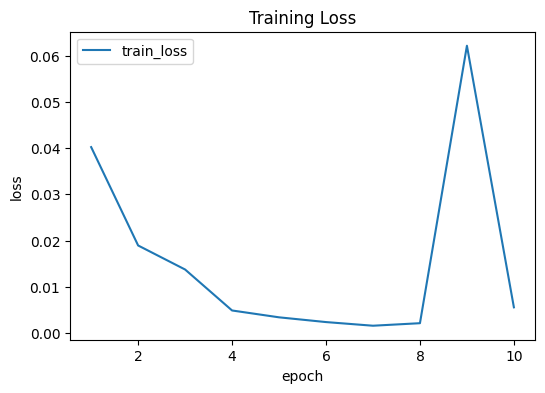

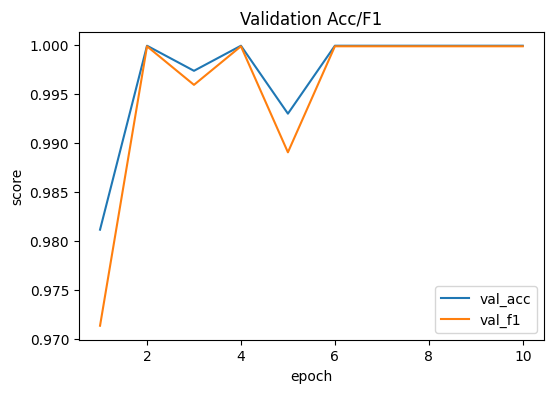

In [ ]:
# PLOTS
import matplotlib.pyplot as plt

epochs     = [h["epoch"] for h in history]
train_loss = [h["train_loss"] for h in history]
val_loss   = [h.get("val_loss") for h in history]
val_accs   = [h["accuracy"] for h in history]
val_f1s    = [h["f1"] for h in history] 

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, val_loss,   label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Training vs Validation Loss")
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, val_accs, label="val_acc")
plt.plot(epochs, val_f1s,  label="val_f1")
plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Validation Acc/F1")
plt.legend(); plt.show()


**QUICK INFERENCE (load ckpt + compare_images)**

In [ ]:
# QUICK INFERENCE
@torch.no_grad()
def load_model_for_infer(ckpt_path, device):
    state = torch.load(ckpt_path, map_location=device)
    model = SiameseNet(state["backbone"]).to(device)
    model.load_state_dict(state["model"]); model.eval()
    return model, float(state["threshold"]), int(state.get("size", 224))

@torch.no_grad()
def compare_images(model, threshold, img_path1, img_path2, size, device):
    tf = T.Compose([
        T.Lambda(lambda im: binarize_and_crop(im)),
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])
    x1 = tf(Image.open(img_path1)).unsqueeze(0).to(device)
    x2 = tf(Image.open(img_path2)).unsqueeze(0).to(device)
    dist, _, _ = model(x1, x2)
    dist = float(dist.item())
    return {"distance": dist, "threshold": float(threshold), "pred": ("Authentic" if dist < threshold else "Forged")}

model_inf, th_inf, sz_inf = load_model_for_infer(ckpt_path, DEVICE)
rootp = Path(ROOT_PATH)
p_org = next((rootp/"full_org").rglob("*.png"), None) or next((rootp/"ful_org").rglob("*.png"), None)
p_frg = next((rootp/"full_forg").rglob("*.png"), None)
if p_org and p_frg:
    print("Demo (org vs forg):", compare_images(model_inf, th_inf, p_org, p_frg, sz_inf, DEVICE))
else:
    print("Put sample images in full_org/ and full_forg/ to run the demo.")


[VisionBackbone] mambaout_tiny -> out_dim=2304
Demo (org vs forg): {'distance': 1.703213095664978, 'threshold': 0.32116958498954773, 'pred': 'Forged'}


**SANITY CHECK**

In [ ]:
# === SANITY CHECK (optional) ===
print("Classes defined:", 'SiameseNet' in globals(), 'ContrastiveLoss' in globals())
print("BACKBONE =", BACKBONE)


Classes defined: True True
BACKBONE = mambaout_tiny


**SHOW TWO IMAGES + PREDICTION**

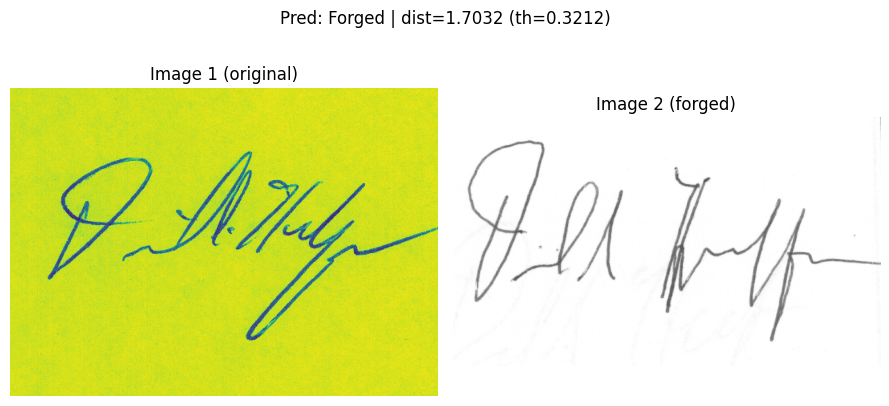

{'distance': 1.703213095664978, 'threshold': 0.32116958498954773, 'pred': 'Forged'}


In [ ]:
# SHOW TWO IMAGES + PREDICTION
from pathlib import Path
import matplotlib.pyplot as plt

def show_pair_and_pred(img1_path: str, img2_path: str, label1="Image 1 (original)", label2="Image 2 (forged)"):
    global model_inf, th_inf, sz_inf
    if 'model_inf' not in globals():
        model_inf, th_inf, sz_inf = load_model_for_infer(ckpt_path, DEVICE)

    res = compare_images(model_inf, th_inf, img1_path, img2_path, sz_inf, DEVICE)

    fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))
    axes[0].imshow(Image.open(img1_path)); axes[0].axis('off'); axes[0].set_title(label1)
    axes[1].imshow(Image.open(img2_path)); axes[1].axis('off'); axes[1].set_title(label2)
    fig.suptitle(f"Pred: {res['pred']} | dist={res['distance']:.4f} (th={res['threshold']:.4f})")
    plt.tight_layout(); plt.show()
    print(res)

# Demo (first png in full_org & full_forg)
rootp = Path(ROOT_PATH)
p_org = next((rootp/'full_org').rglob('*.png'), None) or next((rootp/'ful_org').rglob('*.png'), None)
p_frg = next((rootp/'full_forg').rglob('*.png'), None)
if p_org and p_frg:
    show_pair_and_pred(str(p_org), str(p_frg), "Image 1 (original)", "Image 2 (forged)")
else:
    print("Put images under full_org/ and full_forg/, then call show_pair_and_pred(path1, path2).")


**SALIENCY (SmoothGrad) SIMPLE OVERLAY (keep)**

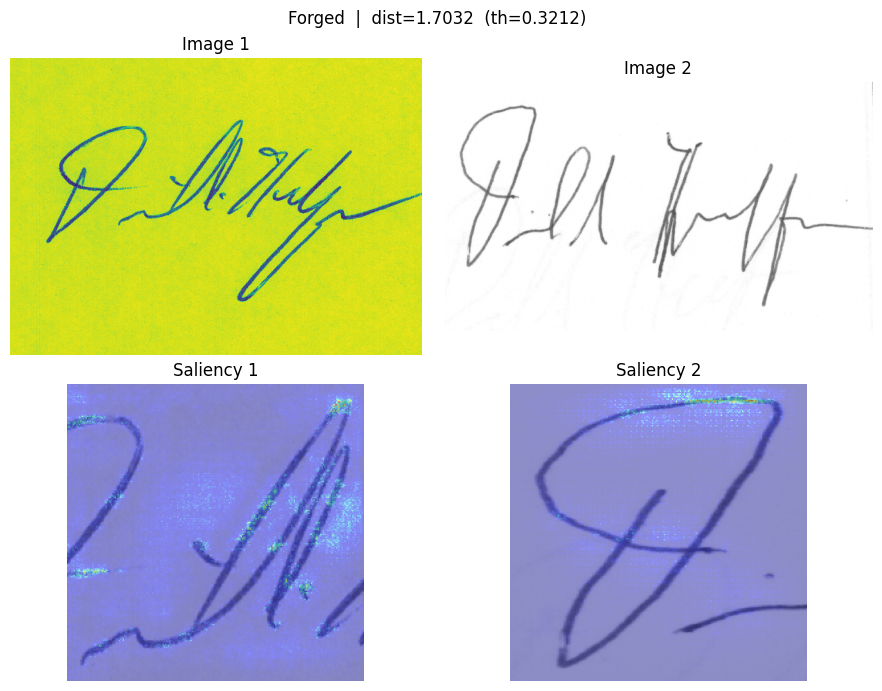

{'distance': 1.703213095664978, 'threshold': 0.32116958498954773, 'pred': 'Forged'}


In [ ]:
# SALIENCY (SmoothGrad) FOR EACH INPUT, OVERLAY HEATMAPS 
import torch
import numpy as np
import matplotlib.pyplot as plt

_tf_no_norm = T.Compose([
    T.Lambda(lambda im: binarize_and_crop(im)),
    T.Resize((sz_inf if 'sz_inf' in globals() else SIZE, sz_inf if 'sz_inf' in globals() else SIZE)),
    T.ToTensor(),  # [0,1]
])
_tf_norm = T.Compose([
    T.Lambda(lambda im: binarize_and_crop(im)),
    T.Resize((sz_inf if 'sz_inf' in globals() else SIZE, sz_inf if 'sz_inf' in globals() else SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

def saliency_pair(model: torch.nn.Module, img1_path: str, img2_path: str,
                  smooth_samples: int = 8, noise_std: float = 0.08):
    model.eval()
    im1 = Image.open(img1_path); im2 = Image.open(img2_path)
    x1n = _tf_norm(im1).unsqueeze(0).to(DEVICE); x2n = _tf_norm(im2).unsqueeze(0).to(DEVICE)
    x1n.requires_grad_(True); x2n.requires_grad_(True)
    x1u = _tf_no_norm(im1); x2u = _tf_no_norm(im2)

    g1 = torch.zeros_like(x1n); g2 = torch.zeros_like(x2n)
    for _ in range(smooth_samples):
        n1 = torch.randn_like(x1n) * noise_std
        n2 = torch.randn_like(x2n) * noise_std
        x1p = (x1n + n1).clamp(-1, 1); x2p = (x2n + n2).clamp(-1, 1)
        if x1n.grad is not None: x1n.grad.zero_()
        if x2n.grad is not None: x2n.grad.zero_()
        model.zero_grad(set_to_none=True)
        d, _, _ = model(x1p, x2p)
        loss = -d.mean()  # pixels that reduce distance → "Authentic" evidence
        loss.backward()
        g1 += x1n.grad.detach().abs(); g2 += x2n.grad.detach().abs()

    g1 /= smooth_samples; g2 /= smooth_samples
    h1 = g1[0].max(dim=0).values; h2 = g2[0].max(dim=0).values
    h1 = (h1 - h1.min()) / (h1.max() - h1.min() + 1e-8)
    h2 = (h2 - h2.min()) / (h2.max() - h2.min() + 1e-8)

    img1_np = x1u.permute(1,2,0).cpu().numpy()
    img2_np = x2u.permute(1,2,0).cpu().numpy()
    return img1_np, img2_np, h1.cpu().numpy(), h2.cpu().numpy()

def show_pair_with_saliency(img1_path: str, img2_path: str,
                            smooth_samples: int = 8, noise_std: float = 0.08):
    global model_inf, th_inf, sz_inf
    if 'model_inf' not in globals():
        model_inf, th_inf, sz_inf = load_model_for_infer(ckpt_path, DEVICE)

    res = compare_images(model_inf, th_inf, img1_path, img2_path, sz_inf, DEVICE)
    img1_np, img2_np, h1_np, h2_np = saliency_pair(model_inf, img1_path, img2_path, smooth_samples, noise_std)

    fig, axes = plt.subplots(2, 2, figsize=(9, 7))
    axes[0,0].imshow(Image.open(img1_path)); axes[0,0].axis('off'); axes[0,0].set_title("Image 1")
    axes[0,1].imshow(Image.open(img2_path)); axes[0,1].axis('off'); axes[0,1].set_title("Image 2")
    axes[1,0].imshow(img1_np); axes[1,0].imshow(h1_np, cmap='jet', alpha=0.45); axes[1,0].axis('off'); axes[1,0].set_title("Saliency 1")
    axes[1,1].imshow(img2_np); axes[1,1].imshow(h2_np, cmap='jet', alpha=0.45); axes[1,1].axis('off'); axes[1,1].set_title("Saliency 2")
    fig.suptitle(f"{res['pred']}  |  dist={res['distance']:.4f}  (th={res['threshold']:.4f})")
    plt.tight_layout(); plt.show()
    print(res)

# Example call (first png it finds in full_org/ + full_forg/)
if 'p_org' in globals() and p_org and 'p_frg' in globals() and p_frg:
    show_pair_with_saliency(str(p_org), str(p_frg))
else:
    print("Provide two paths: show_pair_with_saliency(path1, path2)")


**CONFUSION MATRIX + DISTANCE HISTOGRAMS (VAL & TEST)**

[SAFE] Pairs -> train: 32376 | val: 9372 | test: 5112
[VisionBackbone] mambaout_tiny -> out_dim=2304
== VAL ==


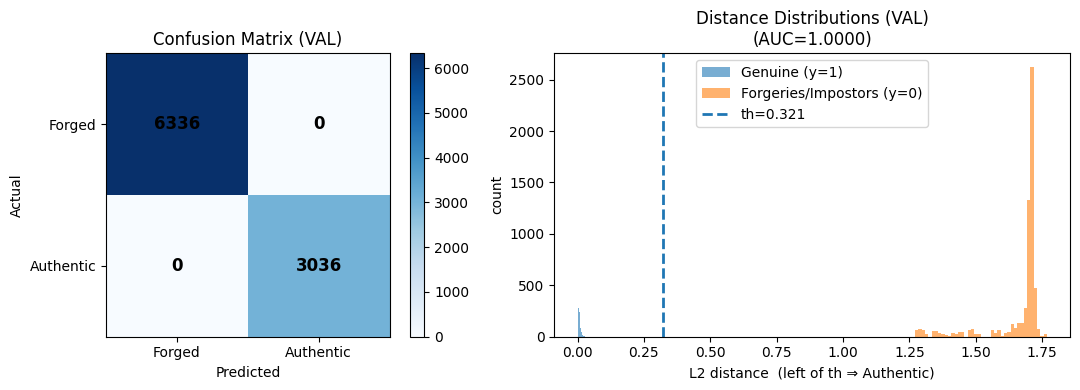

[(VAL)] acc=1.0000 | f1=1.0000 | FAR=0.0000 | FRR=0.0000 | AUC=1.0000 | th=0.3212
== TEST ==


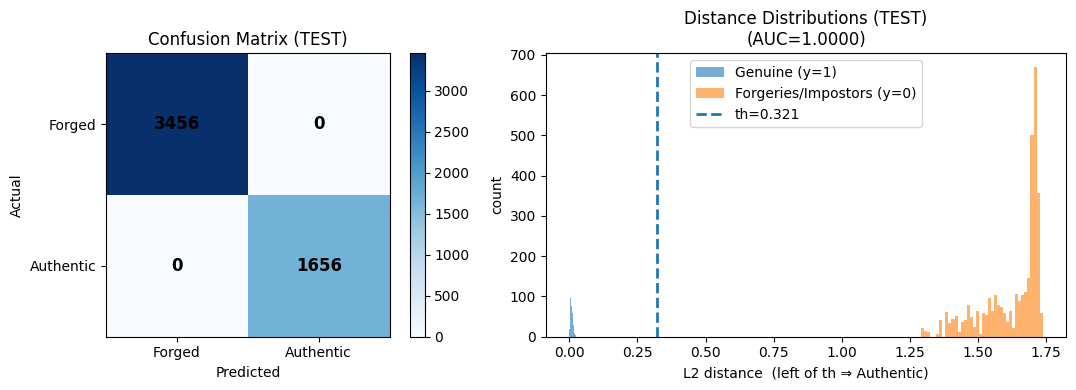

[(TEST)] acc=1.0000 | f1=1.0000 | FAR=0.0000 | FRR=0.0000 | AUC=1.0000 | th=0.3212


In [ ]:
    # === CONFUSION MATRIX + DISTANCE HISTOGRAMS (VAL & TEST) ===
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

@torch.no_grad()
def _eval_and_visualize_confusion(model, loader, device, threshold, title_note="(set)"):
    dists, labels = collect_scores(model, loader, device)
    if dists.size == 0:
        print("No data.")
        return None

    preds = (dists < threshold).astype(int)
    y = labels.astype(int)

    acc = accuracy_score(y, preds)
    f1  = f1_score(y, preds)
    cm  = confusion_matrix(y, preds)
    far, frr = far_frr_at_threshold(dists, y, threshold)
    auc  = auc_from_dist(dists, y)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax = axes[0]
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(f"Confusion Matrix {title_note}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Forged", "Authentic"])
    ax.set_yticklabels(["Forged", "Authentic"])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center",
                    color="black", fontsize=12, fontweight="bold")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax2 = axes[1]
    ax2.hist(dists[y==1], bins=40, alpha=0.60, label="Genuine (y=1)")
    ax2.hist(dists[y==0], bins=40, alpha=0.60, label="Forgeries/Impostors (y=0)")
    ax2.axvline(threshold, linestyle="--", linewidth=2, label=f"th={threshold:.3f}")
    ax2.set_title(f"Distance Distributions {title_note}\n(AUC={auc:.4f})")
    ax2.set_xlabel("L2 distance  (left of th ⇒ Authentic)")
    ax2.set_ylabel("count"); ax2.legend()
    plt.tight_layout(); plt.show()

    print(f"[{title_note}] acc={acc:.4f} | f1={f1:.4f} | FAR={far:.4f} | FRR={frr:.4f} | AUC={auc:.4f} | th={threshold:.4f}")
    return {"accuracy":acc, "f1":f1, "far":far, "frr":frr, "auc":auc, "threshold":float(threshold), "cm":cm}

# Rebuild loaders to visualize on same splits
_, val_loader_vis, test_loader_vis = make_loaders(
    ROOT, SIZE, BATCH, SEED, CAP_TOTAL_PAIRS, WRITER_DISJOINT_SPLIT
)

# Load best model/threshold
model_vis, th_vis, _ = load_model_for_infer(ckpt_path, DEVICE)

print("== VAL ==")
val_vis = _eval_and_visualize_confusion(model_vis, val_loader_vis, DEVICE, th_vis, title_note="(VAL)")
print("== TEST ==")
test_vis = _eval_and_visualize_confusion(model_vis, test_loader_vis, DEVICE, th_vis, title_note="(TEST)")


In [ ]:
# === MODEL SUMMARY: Siamese Vision Mamba ===
import torch

def print_siamese_summary(model, size=SIZE, device=DEVICE):
    model.eval()
    x = torch.randn(1, 3, size, size, device=device)
    with torch.no_grad():
        d, e1, e2 = model(x, x)

    print("Model: SiameseNet (Vision Mamba)")
    print(f"Input 1 shape: {tuple(x.shape)}")
    print(f"Input 2 shape: {tuple(x.shape)}")
    print(f"Embedding e1 shape: {tuple(e1.shape)}")
    print(f"Embedding e2 shape: {tuple(e2.shape)}")
    print(f"Distance head output shape: {tuple(d.shape)}")

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Non-trainable params: {total_params - trainable_params:,}")

    # Optional: detailed per-layer table if torchinfo is available
    try:
        from torchinfo import summary as torchinfo_summary
        print("\n[torchinfo] Layer-by-layer summary:")
        torchinfo_summary(model, input_size=[(1, 3, size, size), (1, 3, size, size)], verbose=0, col_names=("input_size","output_size","num_params","kernel_size","mult_adds"))
    except Exception:
        print("(Install `torchinfo` for a detailed layer table.)")

# Example (after training / or using a freshly constructed model)
try:
    model_tmp = SiameseNet(BACKBONE).to(DEVICE)
    print_siamese_summary(model_tmp, size=SIZE, device=DEVICE)
except Exception as e:
    print("Could not create/inspect model:", e)


In [ ]:
# === RANDOM TEST PAIR PREDICTION & DISPLAY ===
import matplotlib.pyplot as plt
import numpy as np
import torch

def predict_score(model, test_loader, device, threshold: float):
    r"""
    Predict distance score and classify a random test pair as Genuine or Forged.
    """
    model.eval()
    (x1, x2, y) = next(iter(test_loader))
    x1, x2, y = x1[0:1].to(device), x2[0:1].to(device), int(y[0].item())

    with torch.no_grad():
        dist, _, _ = model(x1, x2)
    diff = float(dist.item())

    # de-normalize (assuming Normalize(mean=0.5,std=0.5))
    img1 = (x1[0].detach().cpu().permute(1,2,0).numpy()*0.5+0.5).clip(0,1)
    img2 = (x2[0].detach().cpu().permute(1,2,0).numpy()*0.5+0.5).clip(0,1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(img1); ax1.axis('off'); ax1.set_title('Image 1')
    ax2.imshow(img2); ax2.axis('off'); ax2.set_title('Label: ' + ('Genuine' if y==1 else 'Forged'))
    plt.tight_layout()
    plt.show()

    print(f"Difference Score = {diff:.6f}")
    if diff > threshold:
        print(f"Predicted: Forged (distance > threshold {threshold:.6f})")
    else:
        print(f"Predicted: Genuine (distance <= threshold {threshold:.6f})")

# Example usage (after Cell 16, where we already loaded model_vis/th_vis and re-made loaders):
try:
    _ = predict_score(model_vis, test_loader_vis, DEVICE, th_vis)
except Exception as e:
    print("Run your training/eval cells first so model/loader/threshold exist.", e)


In [ ]:
predict_score(model_vis, test_loader_vis, DEVICE, th_vis)